In [1]:
import pandas as pd
import numpy as np
import json
import requests 
from bs4 import BeautifulSoup
from IPython.display import clear_output

In [2]:
df=pd.read_csv('data/2020_data_clean.csv')
df.head()

,Unnamed: 0,name,lastName,uri,worthChange,age,source_x,industry,gender,country,...,source_y,Source of Wealth,Residence,Citizenship,Marital Status,Children,Education,Self-Made Score,Philanthropy Score,self_made
0,0,A. Jayson Adair,Adair,a-jayson-adair,-12.191,52.0,damaged cars,Automotive,M,United States,...,"['damaged cars', ' Self Made']","damaged cars, Self Made","Dallas, Texas",United States,Married,2.0,NaN,NaN,NaN,True
1,1,Abhay Soi,Soi,abhay-soi,31.453,48.0,healthcare,Healthcare,M,India,...,"['healthcare', ' Self Made']","healthcare, Self Made","Mumbai, India",India,Married,2.0,"Master of Business Administration, European Un...",NaN,NaN,True
2,2,Adam Foroughi,Foroughi,adam-foroughi,-147.507,41.0,mobile games,Media & Entertainment,M,United States,...,"['mobile games', ' Self Made']","mobile games, Self Made","Truckee, California",United States,Married,NaN,NaN,NaN,NaN,True
3,3,Adam Neumann,Neumann,adam-neumann,-19.834,42.0,WeWork,Real Estate,M,Israel,...,"['WeWork', ' Self Made']","WeWork, Self Made","New York, New York",Israel,Married,5.0,City University of New York Baruch,NaN,NaN,True
4,4,Alan Miller & family,Miller,alan-miller-1,-5.252,84.0,healthcare services,Healthcare,M,United States,...,"['healthcare services', ' Self Made']","healthcare services, Self Made","Lower Merion, Pennsylvania",United States,Married,3.0,"Bachelor of Arts/Economics, College of William...",NaN,NaN,True


In [3]:
# df.columns

In [4]:
from sklearn import preprocessing

#numbers columns

nums= [ 'worthChange', 'age','realTimeWorth' ] # data excluded : 'Children' 


df.Children=df.Children.fillna(value=0)

x=df[nums].copy(deep=True)

#normalizing the values
x=x.values
normalizer = preprocessing.MinMaxScaler()
# normalizer= preprocessing.Normalizer()  #need to handle NA to do euclidian norm
x_scaled= normalizer.fit_transform(x)
x=pd.DataFrame(x_scaled, columns=nums)

In [5]:
#Boolean columns

df['married']=df['Marital Status'].str.lower().str.contains("married")

bool=[ 'gender','married',  'self_made'] #


for col in bool: 
    x=x.merge(pd.get_dummies(df[col], prefix=col, drop_first=True),how="left", left_index=True, right_index=True)

In [6]:
#categorical columns
cat=[ 'industry',  'country'] #residence(country)

for col in cat: 
    x=x.merge(pd.get_dummies(df[col], prefix=col),how="left", left_index=True, right_index=True)


In [8]:
from sklearn import cluster
kmeans= cluster.KMeans(n_clusters=8, random_state=10).fit(x.dropna())

unique, counts=np.unique(kmeans.labels_, return_counts=True)
dict(zip(unique, counts))

#calculate euclidian distance between centroids vs the other centroids in set for each features/dimensions 
centroids=kmeans.cluster_centers_
distance=[]


for i in range(centroids.shape[0]):
    distance.append(np.sum(centroids[i]-centroids, axis=0))
    
distance= np.array(distance)


Computing adjusted_rand_score for 10 values of n_clusters
done in 0.877s
Computing v_measure_score for 10 values of n_clusters
done in 0.853s
Computing ami_score for 10 values of n_clusters
done in 0.880s
Computing mutual_info_score for 10 values of n_clusters
done in 0.846s


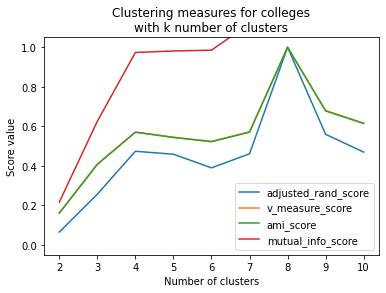

In [9]:
#checking metrics to see what cluster number is optimal

import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn import metrics
import sklearn

def uniform_labelings_scores(score_func, n_clusters_range, y, dfex,
                             n_runs=1):
    """Compute score for 2 random uniform cluster labelings.

    Both random labelings have the same number of clusters for each value
    possible value in ``n_clusters_range``.

    When fixed_n_classes is not None the first labeling is considered a ground
    truth class assignment with fixed number of classes.
    """

    scores = np.zeros((len(n_clusters_range), n_runs))



    for i, k in enumerate(n_clusters_range):
        for j in range(n_runs):
            labels_a = y
            labels_b = sklearn.cluster.KMeans(n_clusters=k, random_state=10).fit(dfex).labels_
            scores[i, j] = score_func(labels_a, labels_b)
    return scores



def ami_score(U, V):
    return metrics.adjusted_mutual_info_score(U, V)

score_funcs = [
    metrics.adjusted_rand_score,
    metrics.v_measure_score,
    ami_score,
    metrics.mutual_info_score,
]


n_clusters_range = np.linspace(2, 10, 10).astype(int)

plt.figure(1)

plots = []
names = []
for score_func in score_funcs:
    print("Computing %s for %d values of n_clusters"
          % (score_func.__name__, len(n_clusters_range)))

    t0 = time()
    scores = uniform_labelings_scores(score_func, n_clusters_range, kmeans.labels_, x.dropna())
    print("done in %0.3fs" % (time() - t0))
    plots.append(plt.errorbar(
        n_clusters_range, np.median(scores, axis=1), scores.std(axis=1))[0])
    names.append(score_func.__name__)

plt.title("Clustering measures for colleges\n"
          "with k number of clusters")
plt.xlabel('Number of clusters')
plt.ylabel('Score value')
plt.legend(plots, names)
plt.ylim(bottom=-0.05, top=1.05)


plt.ylim(bottom=-0.05, top=1.05)
plt.legend(plots, names)
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.11572517369477883
For n_clusters = 3 The average silhouette_score is : 0.13324517787992404
For n_clusters = 4 The average silhouette_score is : 0.13987929766191898
For n_clusters = 5 The average silhouette_score is : 0.11414285716384845
For n_clusters = 6 The average silhouette_score is : 0.12620692193091185
For n_clusters = 7 The average silhouette_score is : 0.1465924321299846
For n_clusters = 8 The average silhouette_score is : 0.1412192248242536


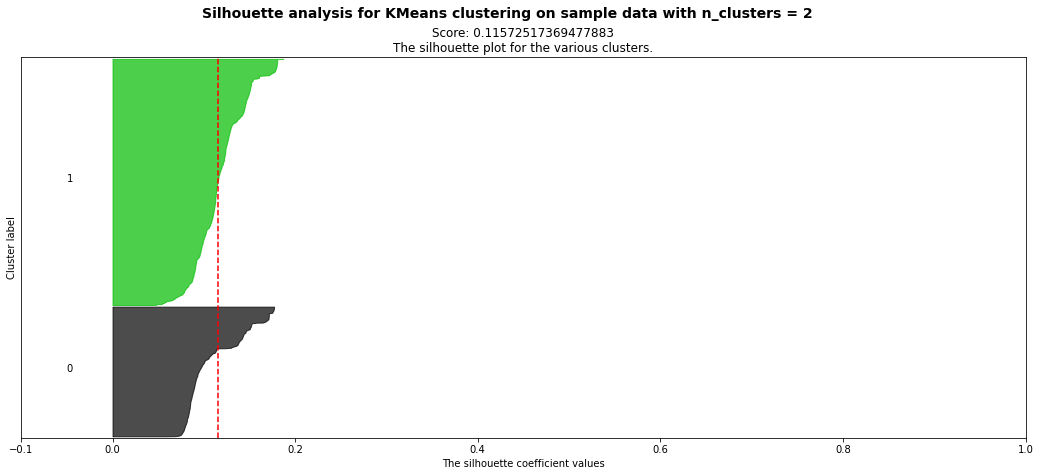

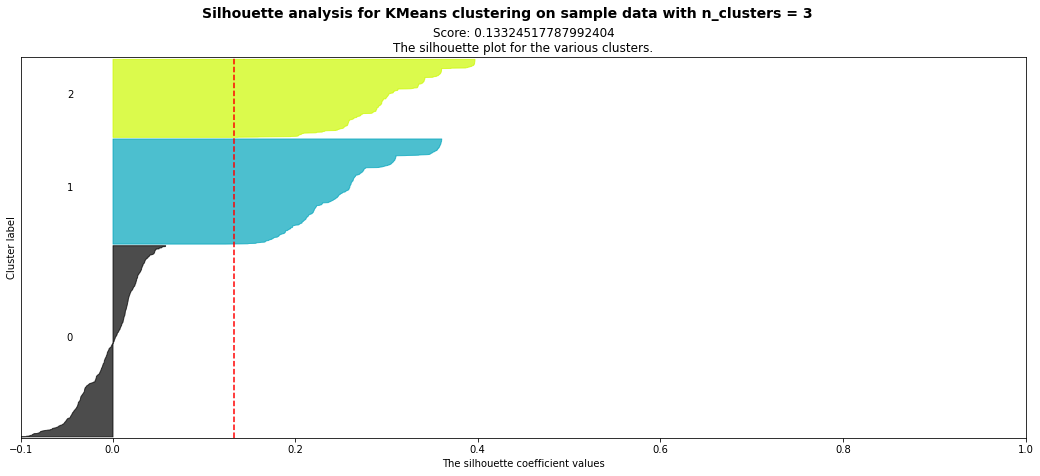

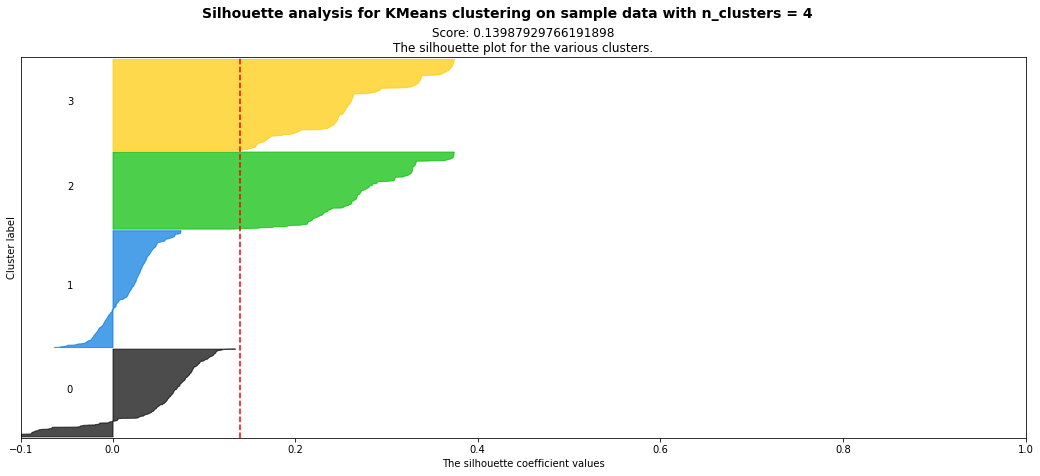

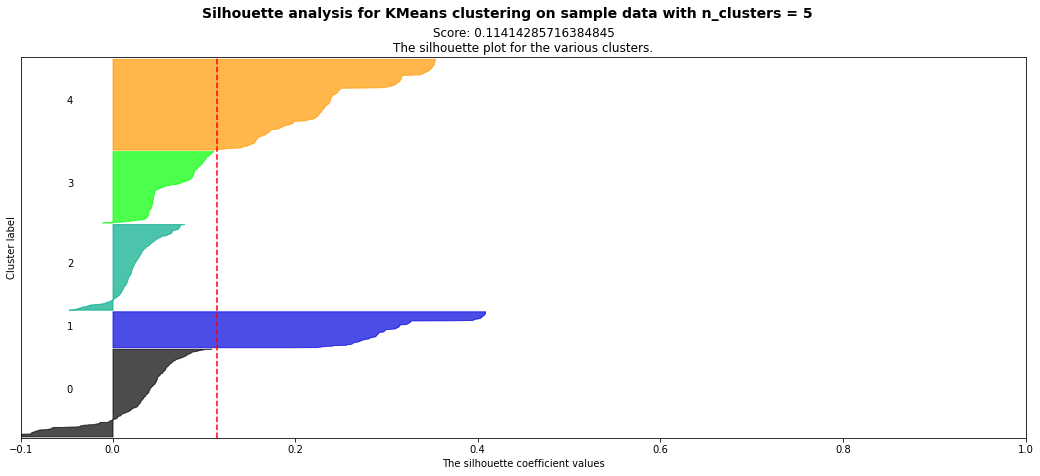

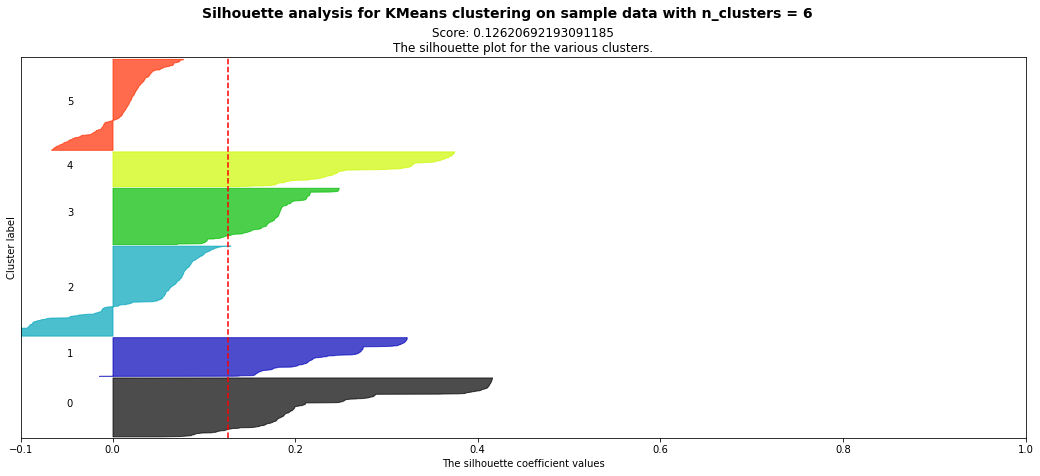

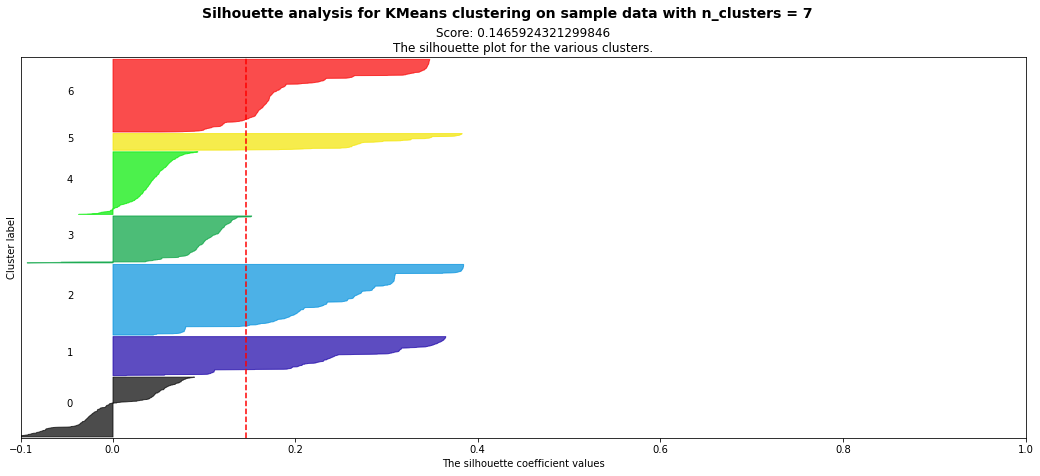

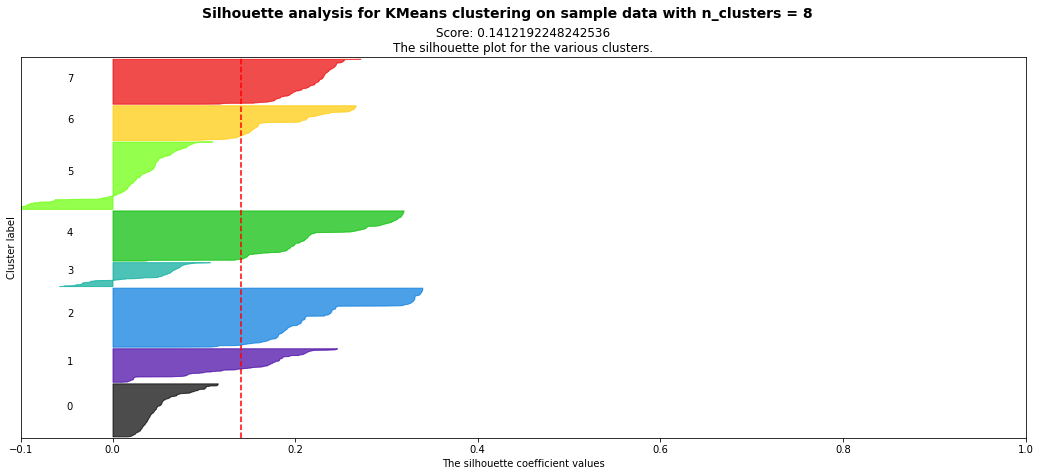

In [10]:
def cluster_silhouette(dfx, target, n_cluster, random_state, min_cluster=2):

    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import numpy as np

    X= dfx
    y=target

    range_n_clusters = np.arange(min_cluster, n_cluster+1)

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        # fig, (ax1, ax2) = plt.subplots(1, 2)
        fig, (ax1) = plt.subplots(1, 1)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state= random_state)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
            "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title(f'Score: {silhouette_avg}\nThe silhouette plot for the various clusters.')
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                    "with n_clusters = %d" % n_clusters),
                    fontsize=14, fontweight='bold')

    plt.show()

labels=kmeans.labels_
cluster_silhouette(x.dropna(), labels, n_cluster=8, random_state=10)

In [11]:
#looks like cluster of size 5 and 8 seems to give the best clustering

In [12]:

def get_relevant_features(dist_matrix, features_name):

    matrix_abs =np.abs(dist_matrix)
    sorted_centroid_features_idx = matrix_abs.argsort(axis=1)[:,::-1]
    # sorted_centroid_features_values = np.take_along_axis(dist_matrix, sorted_centroid_features_idx, axis=1)

    relevant_feat=[]
    for i in range(dist_matrix.shape[0]):
        first_features_in_centroid_1 = dist_matrix[i][sorted_centroid_features_idx[i]][:10]
        relevant_feat.append(list(
                zip(
                    [features_name[feature] for feature in sorted_centroid_features_idx[i]], 
                    first_features_in_centroid_1
                )
            ))

    return relevant_feat

In [13]:
#get relevant features but also add true postion of the center
def get_relevant_features2(dist_matrix, centroids, features_name):

    matrix_abs =np.abs(dist_matrix)
    sorted_centroid_features_idx = matrix_abs.argsort(axis=1)[:,::-1]
    # sorted_centroid_features_values = np.take_along_axis(dist_matrix, sorted_centroid_features_idx, axis=1)

    relevant_feat=[]
    for i in range(dist_matrix.shape[0]):
        relevant_features_weight = dist_matrix[i][sorted_centroid_features_idx[i]][:10]
        relevant_features_value = centroids[i][sorted_centroid_features_idx[i]][:10]
        
        relevant_feat.append(list(
                zip(
                    [features_name[feature] for feature in sorted_centroid_features_idx[i]], 
                    relevant_features_weight,
                    relevant_features_value
                )
            ))

    return relevant_feat

In [14]:
#only positive weight
def get_relevant_features_pos(dist_matrix, centroids, features_name):

    # matrix_abs =np.abs(dist_matrix)
    sorted_centroid_features_idx = dist_matrix.argsort(axis=1)[:,::-1]
    # sorted_centroid_features_values = np.take_along_axis(dist_matrix, sorted_centroid_features_idx, axis=1)

    relevant_feat=[]
    for i in range(dist_matrix.shape[0]):
        relevant_features_weight = dist_matrix[i][sorted_centroid_features_idx[i]][:10]
        relevant_features_value = centroids[i][sorted_centroid_features_idx[i]][:10]
        
        relevant_feat.append(list(
                zip(
                    [features_name[feature] for feature in sorted_centroid_features_idx[i]], 
                    relevant_features_weight,
                    relevant_features_value
                )
            ))

    return relevant_feat

In [15]:
from sklearn import cluster
kmeans= cluster.KMeans(n_clusters=8, random_state=10).fit(x.dropna())

unique, counts=np.unique(kmeans.labels_, return_counts=True)
dict(zip(unique, counts))

#calculate euclidian distance between centroids vs the other centroids in set for each features/dimensions 
centroids=kmeans.cluster_centers_
distance=[]


for i in range(centroids.shape[0]):
    distance.append(np.sum(centroids[i]-centroids, axis=0))
    
distance= np.array(distance)


In [16]:
feats=get_relevant_features2(distance,kmeans.cluster_centers_, x.columns)

In [17]:
get_relevant_features_pos(distance,kmeans.cluster_centers_, x.columns)[2]

[('country_China', 6.511266579125818, 0.9999999999999997),
 ('industry_Manufacturing', 1.9217790029000776, 0.3438256658595639),
 ('self_made_True', 1.592034567443735, 0.9612590799031476),
 ('industry_Healthcare', 0.6730958064909431, 0.1549636803874092),
 ('industry_Food & Beverage', 0.18644859525269314, 0.08958837772397098),
 ('industry_Service', 0.17663513670935135, 0.046004842615012066),
 ('industry_Real Estate', 0.17417477624753852, 0.09685230024213064),
 ('industry_Automotive', 0.1339552634751734, 0.041162227602905596),
 ('gender_M', 0.09233903840765212, 0.9128329297820824),
 ('industry_Metals & Mining', 0.08279283606080823, 0.03631961259079902)]

In [18]:
#sometimes it is useful to see who are the most representative members of a cluster
# (aka the points closest to the center of a cluster)

dfx=df.iloc[x.dropna().index]
dfx["kmeans"]=kmeans.labels_
dfx["k_dist"]=kmeans.fit_transform(x.dropna()).min(axis=1) #get distance of each point from their cluster 
#another way to do it pre-assuming the the order of the index from kmeans.fit_transform(x.dropna()) are consistent with kmeans.label_
# dist=kmeans.fit_transform(x.dropna()) 
# dist[np.arange(len(dist)), kmeans.labels_]

C:\Users\JP_cl\AppData\Local\Temp/ipykernel_19052/3930195527.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx["kmeans"]=kmeans.labels_
C:\Users\JP_cl\AppData\Local\Temp/ipykernel_19052/3930195527.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx["k_dist"]=kmeans.fit_transform(x.dropna()).min(axis=1) #get distance of each point from their cluster


In [19]:
cluster_n=4
print(get_relevant_features2(distance,kmeans.cluster_centers_, x.columns)[cluster_n])
dfx.loc[dfx.kmeans==cluster_n].sort_values(by=["k_dist"], axis=0, ascending=True).head(5)

[('industry_Finance & Investments', 6.976347269988641, 1.0000000000000004), ('country_United States', 1.917293358338141, 0.5356125356125359), ('country_China', -1.3519812841220444, 0.017094017094016895), ('industry_Technology', -1.3163481953290872, 8.326672684688674e-17), ('industry_Fashion & Retail', -1.0242130750605332, 5.551115123125783e-17), ('married_True', 1.0069500514731025, 0.7435897435897436), ('industry_Manufacturing', -0.8288263239764342, -4.163336342344337e-17), ('industry_Real Estate', -0.6006436256895074, -9.71445146547012e-17), ('industry_Healthcare', -0.5666136366083306, -1.3877787807814457e-17), ('gender_M', 0.5389633494387427, 0.9686609686609687)]


,Unnamed: 0,name,lastName,uri,worthChange,age,source_x,industry,gender,country,...,Citizenship,Marital Status,Children,Education,Self-Made Score,Philanthropy Score,self_made,married,kmeans,k_dist
1154,1154,John Paulson,Paulson,john-paulson,0.000,65.0,hedge funds,Finance & Investments,M,United States,...,United States,Married,2.0,"Master of Business Administration, Harvard Bus...",9.0,2.0,True,True,4,0.584432
1476,1476,"Stephen Mandel, Jr.",Mandel,stephen-mandel-jr,0.000,65.0,hedge funds,Finance & Investments,M,United States,...,United States,Married,3.0,"Bachelor of Arts/Science, Dartmouth College; M...",7.0,2.0,True,True,4,0.584434
1850,1850,Vincent Viola,Viola,vincent-viola,-39.423,65.0,electronic trading,Finance & Investments,M,United States,...,United States,Married,3.0,"Doctor of Jurisprudence, New York Law School; ...",9.0,1.0,True,True,4,0.584437
1184,1184,Tony Tamer,Tamer,tony-tamer,0.000,64.0,private equity,Finance & Investments,M,United States,...,United States,Married,4.0,"Master of Business Administration, Harvard Bus...",8.0,NaN,True,True,4,0.584488
1958,1958,Jonathan Nelson,Nelson,jonathan-nelson,0.000,65.0,private equity,Finance & Investments,M,United States,...,United States,"Widowed, Remarried",3.0,"Bachelor of Arts/Science, Brown University; Ma...",8.0,NaN,True,True,4,0.584495


In [20]:

def get_relevant_features(dist_matrix, features_name, n_features=10):

    matrix_abs =np.abs(dist_matrix)
    sorted_centroid_features_idx = matrix_abs.argsort(axis=1)[:,::-1]
    # sorted_centroid_features_values = np.take_along_axis(dist_matrix, sorted_centroid_features_idx, axis=1)

    relevant_feat=[]
    for i in range(dist_matrix.shape[0]):
        first_features_in_centroid_1 = dist_matrix[i][sorted_centroid_features_idx[i]][:n_features]
        relevant_feat.append(dict(
                zip(
                    [features_name[feature] for feature in sorted_centroid_features_idx[i]], 
                    first_features_in_centroid_1
                )
            ))

    return relevant_feat

feats=get_relevant_features(distance, x.columns)

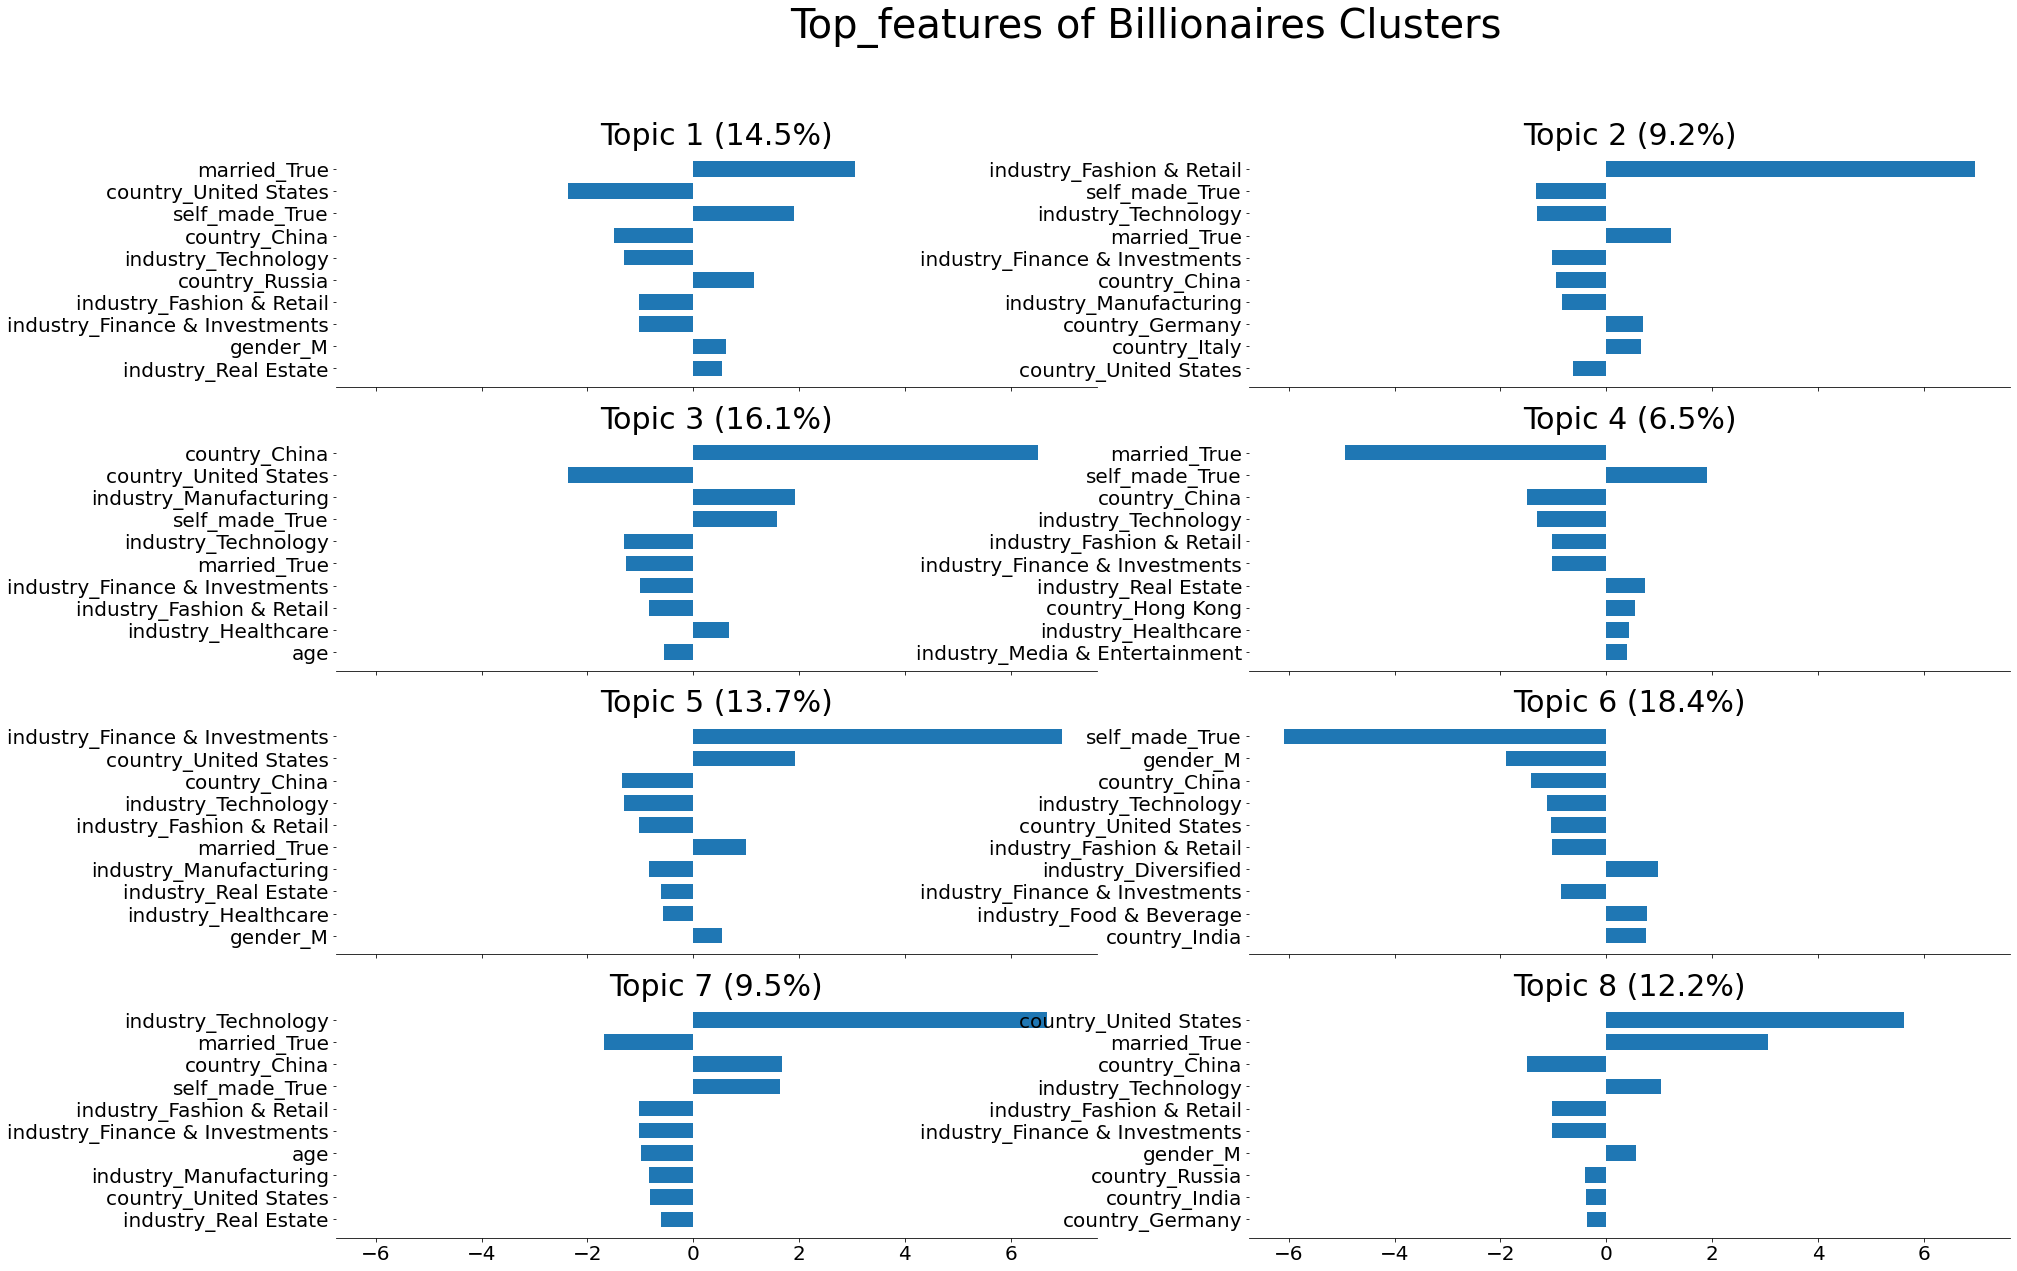

In [21]:
clusters=get_relevant_features(distance, x.columns, n_features=10)

unique, counts=np.unique(kmeans.labels_, return_counts=True)
counts= np.round_((counts/sum(counts))*100, decimals=1) #turn it into %


title="Top_features of Billionaires Clusters"
fig, axes = plt.subplots(4, 2, figsize=(30, 20), sharex=True)
axes = axes.flatten()

for cluster_idx,cluster in enumerate(clusters):
    top_features = list(cluster.keys())
    weights=list(cluster.values())
    ax = axes[cluster_idx]
    ax.barh(top_features, weights, height=0.7)
    ax.set_title(f'Topic {cluster_idx +1} ({counts[cluster_idx]}%)',
                    fontdict={'fontsize': 30})
    ax.invert_yaxis()
    ax.tick_params(axis='both', which='major', labelsize=20)
    for i in 'top right left'.split():
        ax.spines[i].set_visible(False)
    fig.suptitle(title, fontsize=40)
    
    

In [ ]:
def feature_classifier(x, labels, n_feature=10):
    relevant_feat=[]
    for i in range(len(a)):

        binary_cat=np.where(labels==i, 1, 0)

        clf = RandomForestClassifier(random_state=1)


        clf.fit(x.dropna().values, binary_cat)

        # Index sort the most important features
        sorted_feature_weight_idxes = np.argsort(clf.feature_importances_)[::-1] # Reverse sort

        # Get the most important features names and weights
        most_important_features = np.take_along_axis(
            np.array(x.columns.tolist()), 
            sorted_feature_weight_idxes, axis=0)
        most_important_weights = np.take_along_axis(
            np.array(clf.feature_importances_), 
            sorted_feature_weight_idxes, axis=0)

        relevant_feat.append(dict(list(zip(most_important_features, most_important_weights))[:n_feature]))

    return relevant_feat



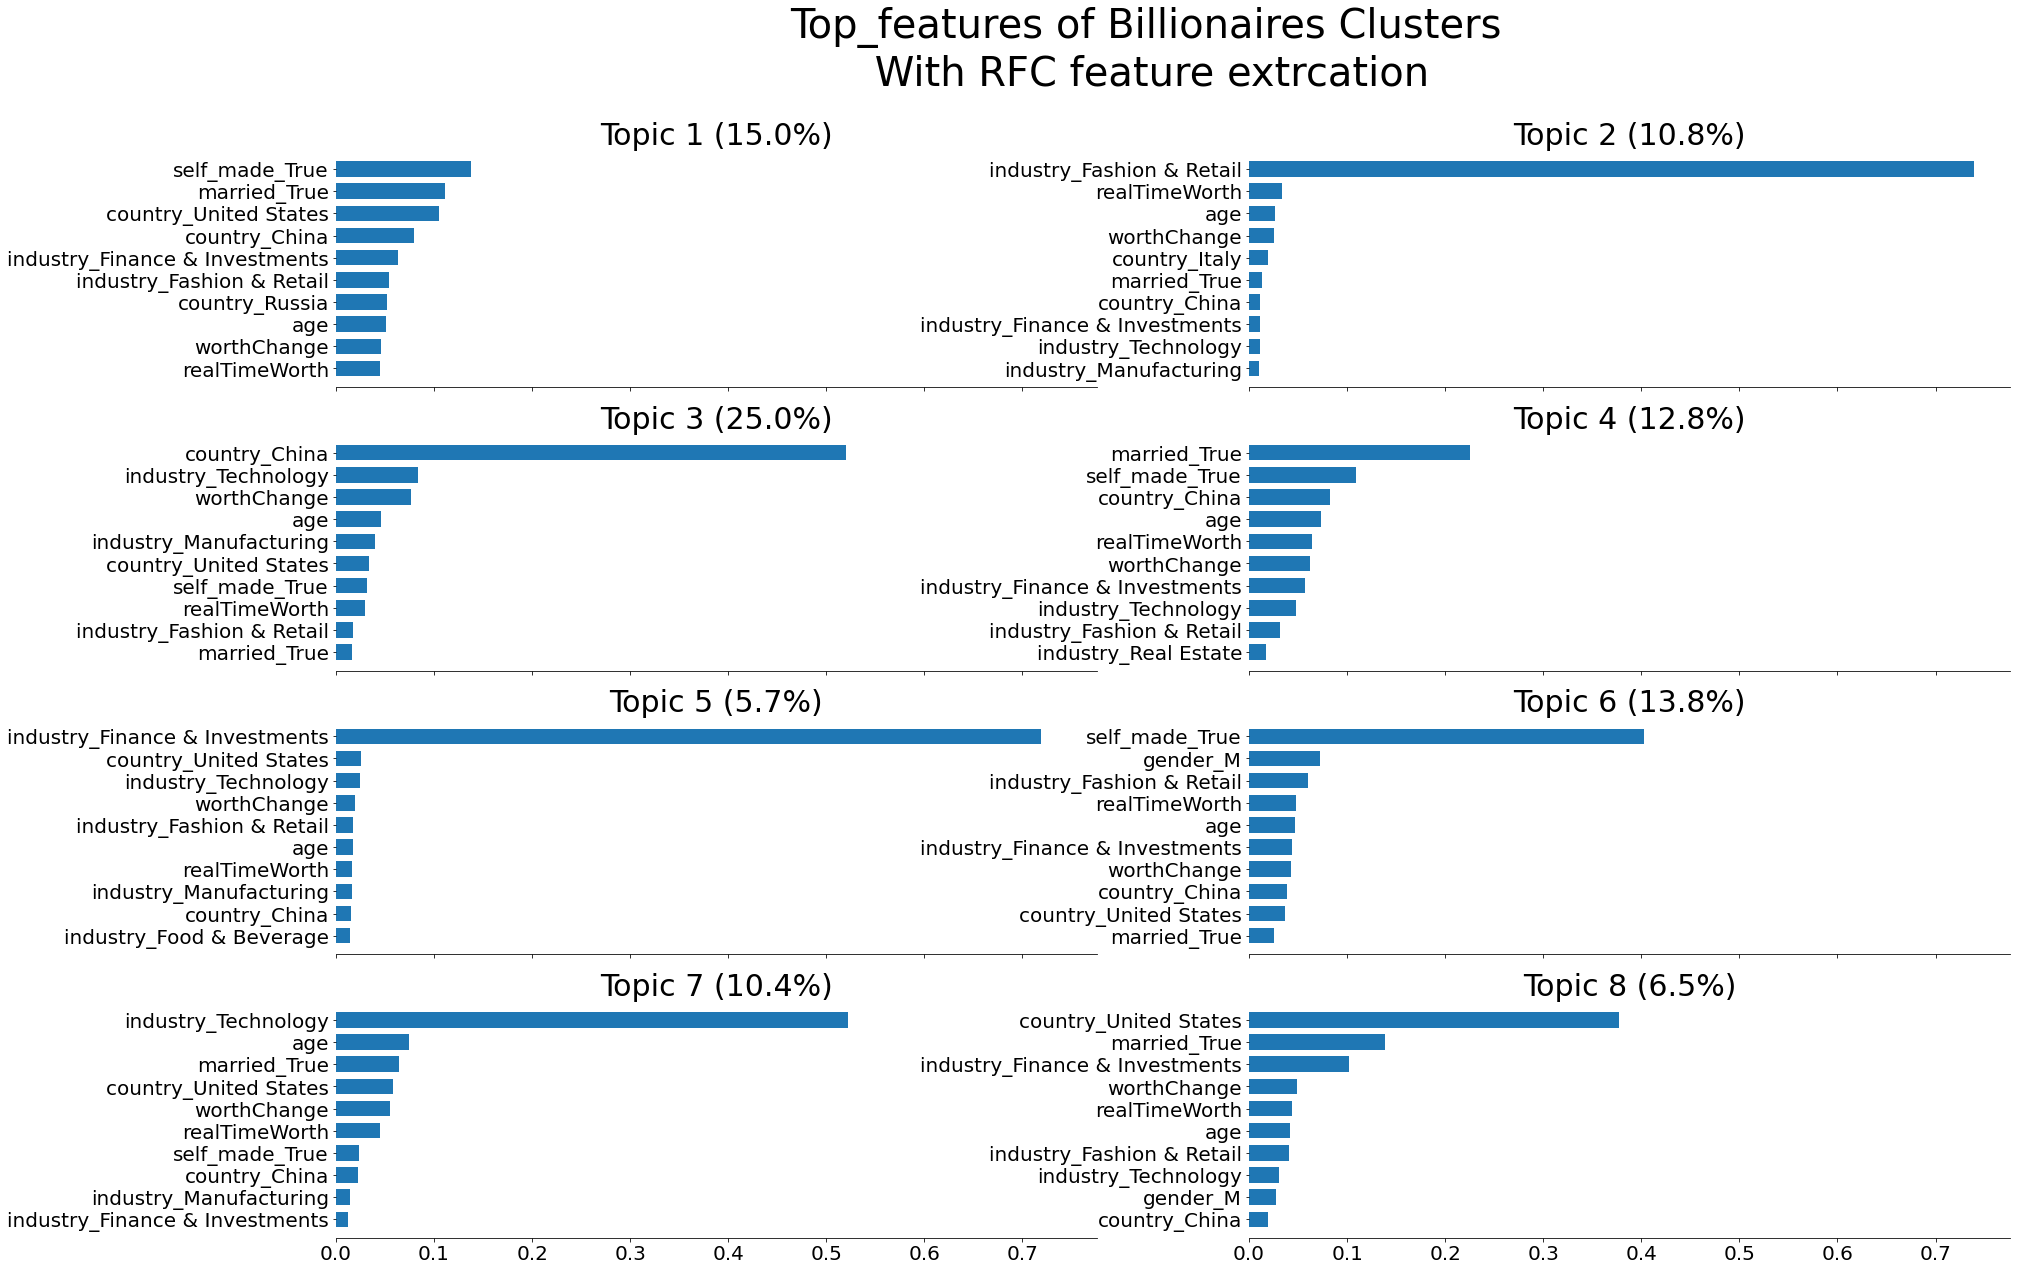

In [107]:
clusters=feature_classifier(x.dropna(), kmeans.labels_, n_feature=10)
unique, counts=np.unique(clustering.labels_, return_counts=True)
counts= np.round_((counts/sum(counts))*100, decimals=1) #turn it into %


title="Top_features of Billionaires Clusters\n With RFC feature extrcation"
fig, axes = plt.subplots(4, 2, figsize=(30, 20), sharex=True)
axes = axes.flatten()

for cluster_idx,cluster in enumerate(clusters):
    top_features = list(cluster.keys())
    weights=list(cluster.values())
    ax = axes[cluster_idx]
    ax.barh(top_features, weights, height=0.7)
    ax.set_title(f'Topic {cluster_idx +1} ({counts[cluster_idx]}%)',
                    fontdict={'fontsize': 30})
    ax.invert_yaxis()
    ax.tick_params(axis='both', which='major', labelsize=20)
    for i in 'top right left'.split():
        ax.spines[i].set_visible(False)
    fig.suptitle(title, fontsize=40)
    
    

In [22]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto',
                 init='random').fit_transform(x.dropna())
X_embedded.shape

(2566, 2)

<AxesSubplot:xlabel='x', ylabel='y'>

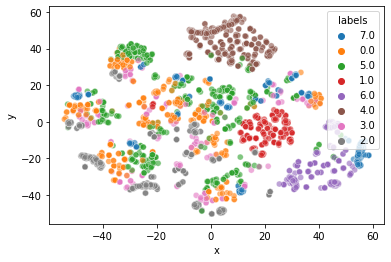

In [23]:
import seaborn as sns

X=np.c_[X_embedded, kmeans.labels_]
df1=pd.DataFrame(data=X, columns=["x", 'y', 'labels'])

df1.labels=df1.labels.astype(str)

sns.scatterplot(x="x", y="y", data=df1, hue="labels", alpha=0.6)

<AxesSubplot:xlabel='x', ylabel='y'>

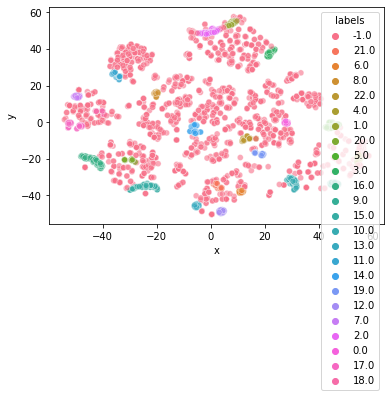

In [35]:
from sklearn.cluster import OPTICS
clustering = OPTICS(min_samples=20).fit(x.dropna())
clustering.labels_

X=np.c_[X_embedded,clustering.labels_ ]
df1=pd.DataFrame(data=X, columns=["x", 'y', 'labels'])

df1.labels=df1.labels.astype(str)

sns.scatterplot(x="x", y="y", data=df1, hue="labels", alpha=0.6)

<AxesSubplot:xlabel='x', ylabel='y'>

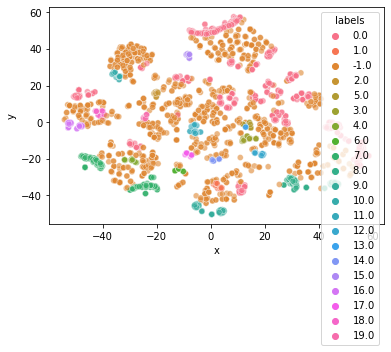

In [58]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=1.2, min_samples=15).fit(x.dropna())
clustering.labels_

X=np.c_[X_embedded,clustering.labels_ ]
df1=pd.DataFrame(data=X, columns=["x", 'y', 'labels'])

df1.labels=df1.labels.astype(str)

sns.scatterplot(x="x", y="y", data=df1, hue="labels", alpha=0.6)

<AxesSubplot:xlabel='x', ylabel='y'>

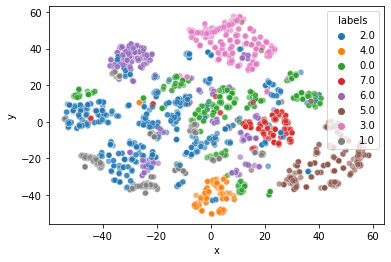

In [59]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=8).fit(x.dropna())

X=np.c_[X_embedded,clustering.labels_ ]
df1=pd.DataFrame(data=X, columns=["x", 'y', 'labels'])

df1.labels=df1.labels.astype(str)

sns.scatterplot(x="x", y="y", data=df1, hue="labels", alpha=0.6)

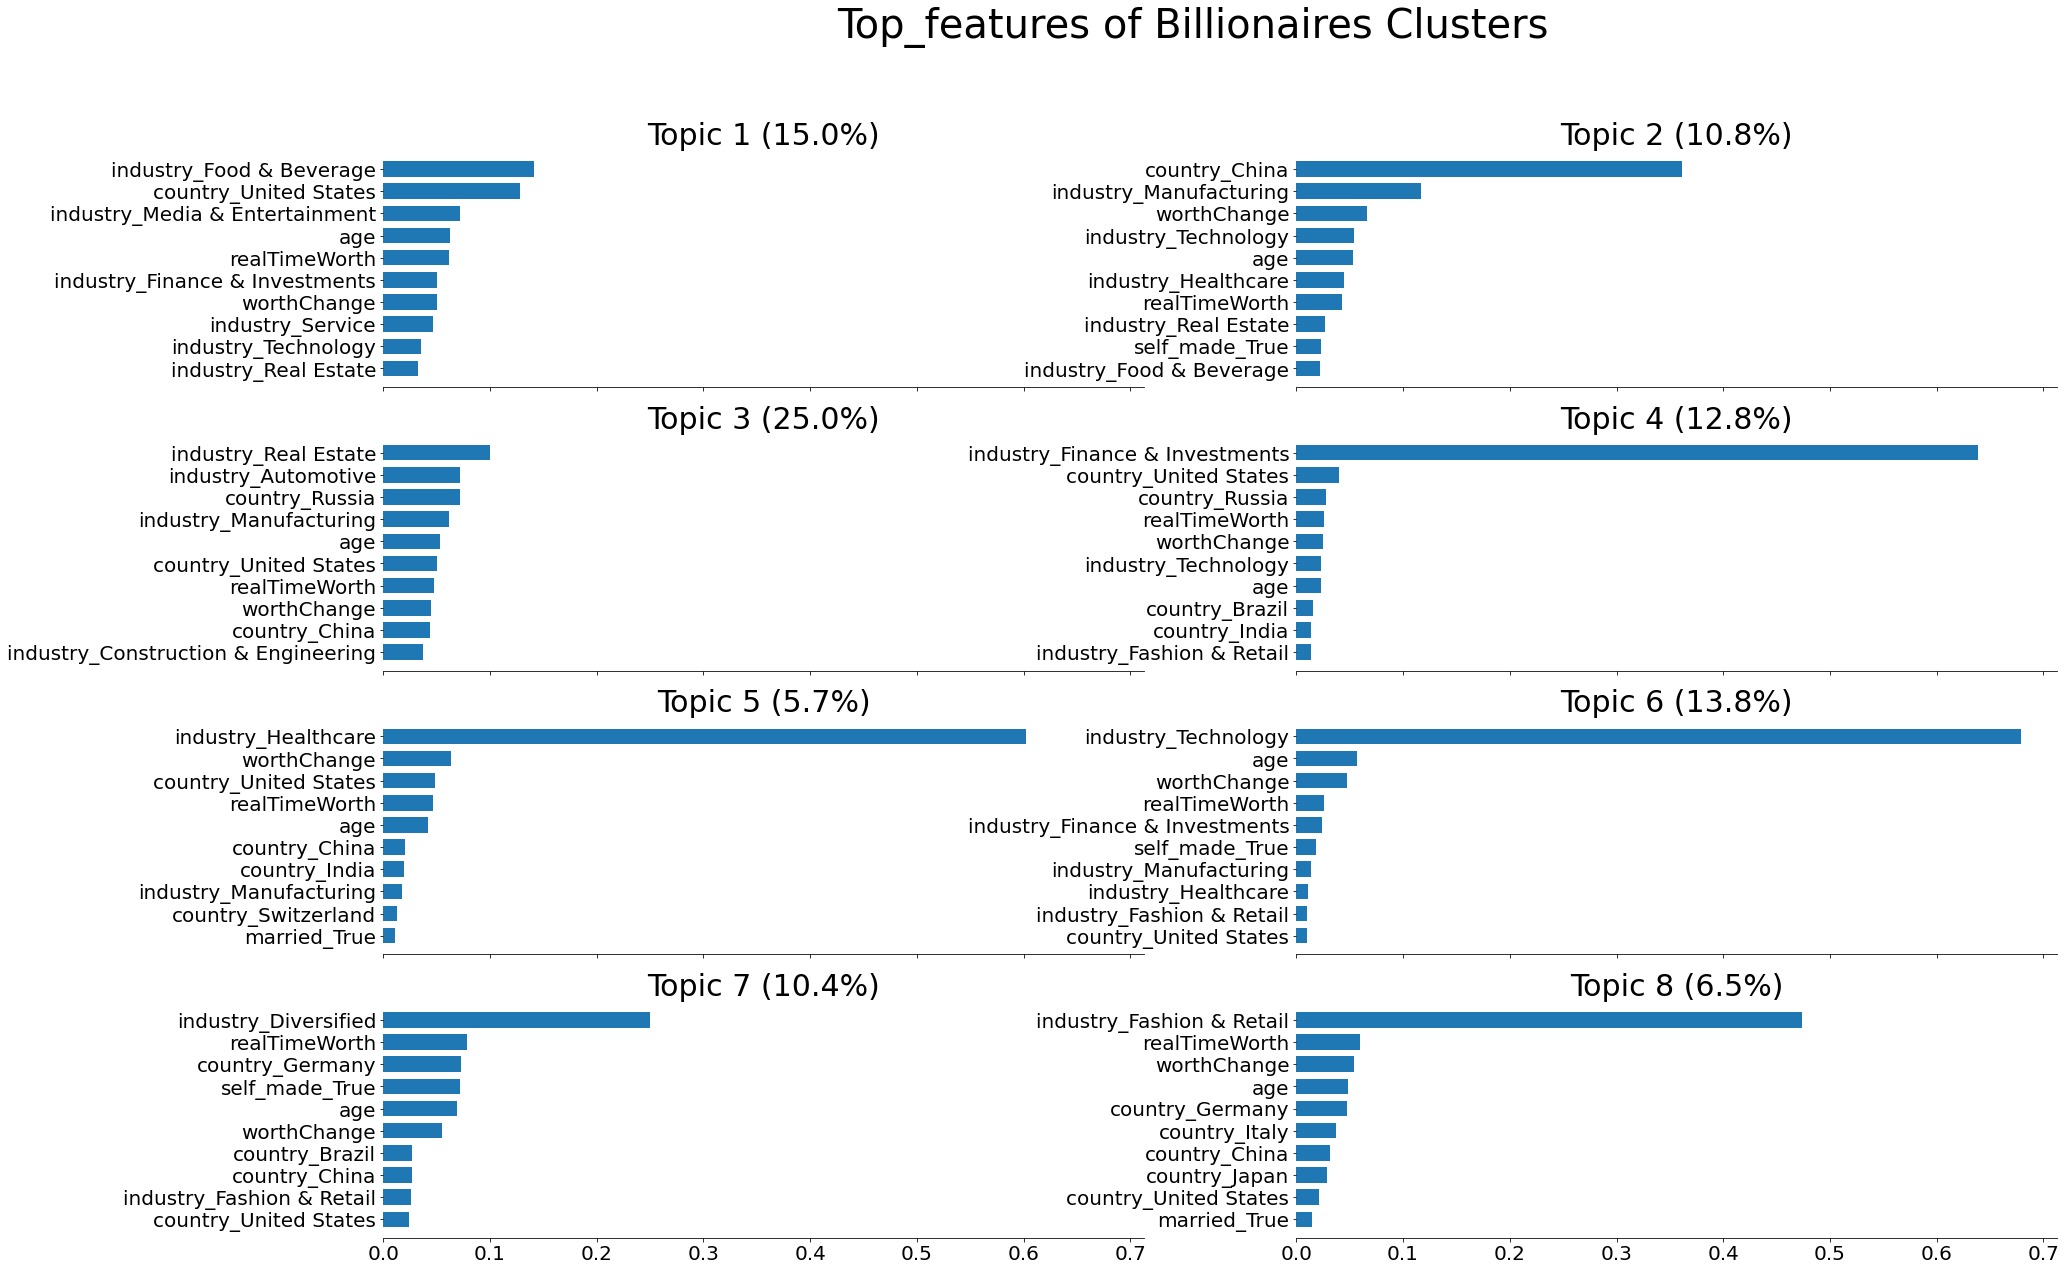

In [105]:
clusters=feature_classifier(x.dropna(), clustering.labels_, n_feature=10)
unique, counts=np.unique(clustering.labels_, return_counts=True)
counts= np.round_((counts/sum(counts))*100, decimals=1) #turn it into %


title="Top_features of Billionaires Clusters"
fig, axes = plt.subplots(4, 2, figsize=(30, 20), sharex=True)
axes = axes.flatten()

for cluster_idx,cluster in enumerate(clusters):
    top_features = list(cluster.keys())
    weights=list(cluster.values())
    ax = axes[cluster_idx]
    ax.barh(top_features, weights, height=0.7)
    ax.set_title(f'Topic {cluster_idx +1} ({counts[cluster_idx]}%)',
                    fontdict={'fontsize': 30})
    ax.invert_yaxis()
    ax.tick_params(axis='both', which='major', labelsize=20)
    for i in 'top right left'.split():
        ax.spines[i].set_visible(False)
    fig.suptitle(title, fontsize=40)
    
    